In [1]:
import math
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
from copy import deepcopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import torch
from torch import nn
import torch.nn.functional as F

import torch_geometric as tg
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_add_pool

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Datasets and Dataloaders

### Feature Extraction

In [2]:
def one_hot_encoding_unk(value, choices: list) -> list:
    # One hot encoding with unknown value handling
    # If the value is in choices, it puts a 1 at the corresponding index
    # Otherwise, it puts a 1 at the last index (unknown)
    encoding = [0] * (len(choices) + 1)
    index = choices.index(value) if value in choices else -1
    encoding[index] = 1
    return encoding


def get_atom_features(atom) -> list:
    # Returns a feature list for the atom
    # Concatenates the one-hot encodings into a single list
    atom_features = [
        one_hot_encoding_unk(atom.GetSymbol(), ['B','Be','Br','C','Cl','F','I','N','Nb','O','P','S','Se','Si','V','W']),
        one_hot_encoding_unk(atom.GetTotalDegree(), [0, 1, 2, 3, 4, 5]),
        one_hot_encoding_unk(atom.GetFormalCharge(), [-1, -2, 1, 2, 0]),
        one_hot_encoding_unk(int(atom.GetTotalNumHs()), [0, 1, 2, 3, 4]),
        one_hot_encoding_unk(int(atom.GetHybridization()),[
                                                        Chem.rdchem.HybridizationType.SP,
                                                        Chem.rdchem.HybridizationType.SP2,
                                                        Chem.rdchem.HybridizationType.SP3,
                                                        Chem.rdchem.HybridizationType.SP3D,
                                                        Chem.rdchem.HybridizationType.SP3D2
                                                        ]),
        [1 if atom.GetIsAromatic() else 0],
        [atom.GetMass() * 0.01]
    ]
    return sum(atom_features, []) # Flatten the list into a single list


def get_bond_features(bond) -> list:
    # Returns a one-hot encoded feature list for the bond
    bond_fdim = 7

    if bond is None:
        bond_features = [1] + [0] * (bond_fdim - 1)
    else:
        bt = bond.GetBondType()
        bond_features = [
            0,  # Zeroth index indicates if bond is None
            bt == Chem.rdchem.BondType.SINGLE,
            bt == Chem.rdchem.BondType.DOUBLE,
            bt == Chem.rdchem.BondType.TRIPLE,
            bt == Chem.rdchem.BondType.AROMATIC,
            (bond.GetIsConjugated() if bt is not None else 0),
            (bond.IsInRing() if bt is not None else 0)
        ]
    return bond_features

### Dataset Construction

In [3]:
class MolGraph:
    # Returns a custom molecular graph for a given SMILES string
    # Contains atom, bond features and node connectivity
    def __init__(self, smiles: str):
        self.smiles = smiles
        self.atom_features = []
        self.bond_features = []
        self.edge_index = []

        molecule = Chem.MolFromSmiles(self.smiles)
        n_atoms = molecule.GetNumAtoms()

        for atom_1 in range(n_atoms):
            self.atom_features.append(get_atom_features(molecule.GetAtomWithIdx(atom_1)))

            for atom_2 in range(atom_1 + 1, n_atoms):
                bond = molecule.GetBondBetweenAtoms(atom_1, atom_2)
                if bond is None:
                    continue
                bond_features = get_bond_features(bond)
                self.bond_features.append(bond_features)
                self.bond_features.append(bond_features) # Bond features are added twice for both directions
                self.edge_index.extend([(atom_1, atom_2), (atom_2, atom_1)]) # Edge index list with tuples of connected nodes instead of adjacency matrix

In [4]:
class ChemDataset(Dataset):
    def __init__(self, smiles: str, labels, flip_prob: float=0.4, noise_std: float=0.4, precompute: bool=True):
        # Choose here how much noise to add for the denoising task
        super(ChemDataset, self).__init__()
        self.smiles = smiles
        self.labels = labels
        self.cache = {}
        self.flip_prob = flip_prob
        self.noise_std = noise_std
        self.precompute = precompute

        # Precomputing the dataset so the get method is faster, and the GPU doesn't have to wait for the CPU
        if precompute:
            print(f"Precomputing data...")
            with ThreadPoolExecutor(max_workers=4) as executor:
                futures = [
                    executor.submit(self.process_key , idx)
                    for idx in range(len(self.smiles))
                ]

                for future in as_completed(futures):
                    future.result()

            print(f"Precomputation finished. {len(self.cache)} molecules cached.")

    def process_key(self, key):
        # Process the key to get the corresponding molecule graph
        # If the molecule is already cached, return it
        smiles = self.smiles[key]
        if smiles in self.cache.keys():
            molecule = self.cache[smiles]
        else:
            molgraph = MolGraph(smiles)
            molecule = self.molgraph2data(molgraph, key)
            self.cache[smiles] = molecule
        return molecule

    def molgraph2data(self, molgraph, key):
        data = tg.data.Data()

        # Coverting all features and labels to tensors
        # And adding it to the data object
        data.x = torch.tensor(molgraph.atom_features, dtype=torch.float)
        data.edge_index = torch.tensor(molgraph.edge_index, dtype=torch.long).t().contiguous()
        data.edge_attr = torch.tensor(molgraph.bond_features, dtype=torch.float)
        data.y = torch.tensor([self.labels[key]], dtype=torch.float)
        data.smiles = self.smiles[key]

        if self.flip_prob > 0 or self.noise_std > 0:
            # Create a deep copy to avoid modifying original data
            x_noisy = deepcopy(data.x)
            
            # Apply bit flipping to binary features if probability > 0
            if self.flip_prob > 0:
                binary_features = x_noisy[:, :-1]  # All but last column, which contains mass
                flip_mask = torch.rand_like(binary_features) < self.flip_prob
                binary_features[flip_mask] = 1.0 - binary_features[flip_mask]  # Flip 0->1 and 1->0
            
            # Apply Gaussian noise to continuous feature if std > 0
            if self.noise_std > 0:
                mass_feature = x_noisy[:, -1:]  # Just the last column, which contains mass
                # Adding noise which is a percentage of the mass feature
                mass_feature += mass_feature * torch.randn_like(mass_feature) * self.noise_std
            
            data.x_noisy = x_noisy

        return data

    def get(self,key):
        return self.process_key(key)
    
    def __getitem__(self, key):
        # Standard get method for PyTorch Dataset
        return self.process_key(key)

    def len(self):
        return len(self.smiles)

    def __len__(self):
        # Standard len method for PyTorch Dataset
        return len(self.smiles)

### Dataloader construction

In [5]:
def construct_loader(data_df: pd.DataFrame, smiles_column: str, target_column: str, shuffle: bool=True, batch_size: int=16):  
    # Constructs a PyTorch Geometric DataLoader from a DataFrame
    # Takes the SMILES and target column names as input
    assert len(data_df) > 0, "DataFrame is empty"
      
    smiles = data_df[smiles_column].values
    labels = data_df[target_column].values.astype(np.float32)  
    
    dataset = ChemDataset(smiles, labels)
    loader = DataLoader(dataset=dataset,
                            batch_size=batch_size,
                            shuffle=shuffle,
                            pin_memory=True
                       )
    return loader

# Model

### Encoder

In [6]:
class DMPNNConv(MessagePassing): 
    # Extending the MessagePassing class from PyG
    # Used for the convolutional layers in the encoder
    def __init__(self, hidden_size: int):
        super(DMPNNConv, self).__init__(aggr='add') # Sum aggregation function, most expressive aggregation as far as I know
        self.linear = nn.Linear(hidden_size, hidden_size)

    def forward(self, edge_index, edge_attr):
        row, _ = edge_index
        # Since each edge is bidirectional, we do two message passings, one for each direction
        aggregated_message = self.propagate(edge_index, x=None, edge_attr=edge_attr)
        reversed_message = torch.flip(edge_attr.view(edge_attr.size(0) // 2, 2, -1), dims=[1]).view(edge_attr.size(0), -1)

        return aggregated_message, self.linear(aggregated_message[row] - reversed_message)

    def message(self, edge_attr):
        return edge_attr

In [7]:
class GNNEncoder(nn.Module):
    def __init__(self, num_node_features: int, num_edge_features: int, hidden_size: int, mode: str, depth: int, dropout: float):
        super().__init__()
        self.depth = depth
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.mode = mode

        # Encoder layers
        self.edge_init = nn.Linear(num_node_features + num_edge_features, hidden_size)
        self.convs = nn.ModuleList([DMPNNConv(hidden_size) for _ in range(depth)])
        self.edge_to_node = nn.Linear(num_node_features + hidden_size, hidden_size)
        self.pool = global_add_pool  # Not learnable

    def forward(self, data):
        edge_index, edge_attr, batch = data.edge_index, data.edge_attr, data.batch
        
        if self.mode == 'denoise':
            x = data.x_noisy
        elif self.mode == 'predict':
            x = data.x
        else:
            raise ValueError("Invalid mode. Choose 'denoise' or 'predict'.")

        # Edge initialization
        row, _ = edge_index
        h_0 = F.relu(self.edge_init(torch.cat([x[row], edge_attr], dim=1)))
        h = h_0

        # DMPNN Conv layers
        for layer in self.convs:
            _, h = layer(edge_index, h)
            h += h_0
            h = F.dropout(F.relu(h), self.dropout, training=self.training)

        # Edge to node aggregation
        # Re-using the last layer's results for s
        s, _ = self.convs[-1](edge_index, h)
        
        # Due to a recurring error which I can't figure out, we add a check here
        # to ensure that the sizes of s and x match
        # This is a workaround and should be fixed in the future
        # Luckily, this issue only occurs for same-sample batches, which are needed for TTA

        # Pad/truncate s to match x's size
        if s.shape[0] != x.shape[0]:
            # Create tensor with same length as x (regardless of connectivity)
            s_fixed = torch.zeros(x.shape[0], self.hidden_size, device=s.device)
            # Only use the connected nodes we have (first min(s.shape[0], x.shape[0]))
            min_len = min(s.shape[0], x.shape[0]) 
            s_fixed[:min_len] = s[:min_len]
            s = s_fixed

        q = torch.cat([x, s], dim=1)
        h = F.relu(self.edge_to_node(q))

        # Global pooling for the final node embeddings
        embedding = self.pool(h, batch)
        
        return embedding

### Decoder

In [8]:
class GNNDecoder(nn.Module):
    # Decoder for self-supervised denoising task
    # Only reconstructing the node features from the embeddings
    def __init__(self, hidden_size: int, num_node_features: int, dropout: float):
        super().__init__()
        self.lin1 = nn.Linear(hidden_size, hidden_size)
        self.lin2 = nn.Linear(hidden_size, num_node_features)
        self.dropout = dropout

    def forward(self, graph_embedding, batch):
        # The embedding size is (batch_size, hidden_size)
        # We need to expand it per node. First, get how many nodes per graph:
        batch_size = graph_embedding.size(0)
        node_counts = torch.bincount(batch)  # number of nodes in each graph

        # Expand each graph embedding "node_counts[g]" times
        expanded = []
        for g in range(batch_size):
            repeated = graph_embedding[g].unsqueeze(0).repeat(node_counts[g], 1)  # shape = (num_nodes_in_g, hidden_size)
            expanded.append(repeated)

        # Concatenate along node dimension
        expanded = torch.cat(expanded, dim=0)  # total_nodes x hidden_size

        # Decode the node features with dropout
        x_hat = F.relu(self.lin1(expanded))
        x_hat = F.dropout(x_hat, p=self.dropout, training=self.training)  # Apply dropout after activation
        x_hat = self.lin2(x_hat)  # shape = (total_nodes, num_node_features)

        return x_hat

### Prediction Head

In [9]:
class GNNHead(nn.Module):
    # Prediction Head for prediction solubility
    def __init__(self, hidden_size: int, dropout: float):
        super().__init__()
        # Only some FFN layers which get the embedding as input
        self.ffn1 = nn.Linear(hidden_size, hidden_size)
        self.ffn2 = nn.Linear(hidden_size, 1)
        self.dropout = dropout

    def forward(self, graph_embedding):
        x = F.relu(self.ffn1(graph_embedding))
        x = F.dropout(x, self.dropout, training=self.training)
        return self.ffn2(x).squeeze(-1)

### Main Model

In [10]:
class GNN(nn.Module):
    # The main GNN model which brings together the encoder, decoder and head
    # It has two modes, denoise and predict
    # The encoder branches out to the decoder and head
    def __init__(self, num_node_features: int, num_edge_features: int, hidden_size: int=300, depth: int=3, mode: str='denoise', dropout: float=0.1):
        super().__init__()
        self.encoder = GNNEncoder(num_node_features, num_edge_features, hidden_size=hidden_size, mode=mode, depth=depth, dropout=dropout)
        self.head = GNNHead(hidden_size=hidden_size, dropout=dropout)
        self.decoder = GNNDecoder(hidden_size=hidden_size, num_node_features=num_node_features, dropout=dropout)

    def set_mode(self, mode: str):
        # Update the mode in the encoder
        # So the encoder knows if it needs to read noisy or noise-free data
        self.encoder.mode = mode

    def get_embedding(self, data):
        # Get the graph embedding from the encoder
        graph_embedding = self.encoder(data)
        return graph_embedding

    def forward(self, data):
        graph_embedding = self.encoder(data)

        if self.encoder.mode == 'predict':
            prediction = self.head(graph_embedding)
            return prediction
        
        elif self.encoder.mode == 'denoise':
            node_features = self.decoder(graph_embedding, data.batch)
            return node_features
    
        else:
            raise ValueError("Invalid mode. Choose 'predict' or 'denoise'.")
        
    def encode(self, data):
        return self.encoder(data)

In [11]:
class Standardizer:
    # Standardizer for the solubility values
    def __init__(self, mean: float, std: float):
        self.mean = mean
        self.std = std

    def __call__(self, x, rev: bool=False):
        if rev:
            return (x * self.std) + self.mean
        return (x - self.mean) / self.std

In [12]:
def train_epoch(model, loader, optimizer, loss, mode: str, stdzer: Standardizer=None):
    # Train the model for one epoch, either on denoising or prediction task
    model = model.to(device)
    if mode == 'denoise':
        model.set_mode('denoise')
        model.train()
        loss_all = 0

        for batch in loader:
            batch = batch.to(device)
            optimizer.zero_grad()

            out = model(batch)
            result = loss(out, batch.x)
            result.backward()

            optimizer.step()
            loss_all += loss(out, batch.x)

        return math.sqrt(loss_all / len(loader.dataset))

    elif mode == 'predict':
        model.set_mode('predict')
        model.train()
        loss_all = 0

        for batch in loader:
            batch = batch.to(device)
            optimizer.zero_grad()

            out = model(batch)
            result = loss(out, stdzer(batch.y))
            result.backward()

            optimizer.step()
            loss_all += loss(stdzer(out, rev=True), batch.y)

        return math.sqrt(loss_all / len(loader.dataset))
    
    else:
        raise ValueError("Invalid mode. Choose 'denoise' or 'predict'.")


def pred(model, loader, mode: str, stdzer: Standardizer=None):
    # Predict with the model, either on denoising or prediction task
    # No test-time adaptation here, just a simple forward pass
    model = model.to(device)
    if mode == 'denoise':
        model.set_mode('denoise')
        model.eval()

        preds = []
        with torch.no_grad():
            for batch in loader:
                batch = batch.to(device)
                out = model(batch)
                preds.extend(out.cpu().detach().flatten().tolist())
                
        return preds

    elif mode == 'predict':
        model.set_mode('predict')
        model.eval()

        preds = []
        with torch.no_grad():
            for batch in loader:
                batch = batch.to(device)
                out = model(batch)
                pred = stdzer(out, rev=True)
                preds.extend(pred.cpu().detach().tolist())

        return preds
    
    else:
        raise ValueError("Invalid mode. Choose 'denoise' or 'predict'.")


# Training

In [13]:
batch_size = 16
denoise_epochs = 20 # Epochs for training on denoising task
pred_epochs = 30 # Epochs for training on prediction task

# If wanted, we can load an already trained model
save_denoise_model = True  # Set to False if you don't want to save
load_trained_denoise_model = False  # Set to True to skip training and load existing model

save_pred_model = True  # Set to False if you don't want to save
load_trained_pred_model = False  # Set to True to skip training and load existing model

### Loading and Preprocessing the Data

In [ ]:
torch.manual_seed(0)
data_df = pd.read_csv("data/AqSolDBc.csv")
# Drop single atoms    
idx_single = [i for i,s in enumerate(data_df['SmilesCurated']) if Chem.MolFromSmiles(s).GetNumAtoms()==1 or '.' in s]
data_df = data_df.drop(idx_single)
if len(idx_single) > 0:
    print(f"Removing {idx_single} due to single atoms")

test_df = pd.read_csv("data/OChemUnseen.csv")
# Drop some Nonetypes
idx_nonetype = [i for i,s in enumerate(test_df['SMILES']) if Chem.MolFromSmiles(s) is None] # Got an error for a SMILES which was None
test_df = test_df.drop(idx_nonetype)
if len(idx_nonetype) > 0:
    print(f"Removing {idx_nonetype} due to Nonetypes")

# Drop single atoms
idx_single = [i for i,s in enumerate(test_df['SMILES']) if Chem.MolFromSmiles(s).GetNumAtoms()==1 or '.' in s]
test_df = test_df.drop(idx_single)
if len(idx_single) > 0:
    print(f"Removing {idx_single} due to single atoms")

Removing [1263, 1444, 3605, 3702] due to single atoms


[17:54:01] Explicit valence for atom # 1 P, 6, is greater than permitted


Removing [667] due to Nonetypes
Removing [471, 503, 589, 591, 592, 593, 594, 610, 613, 641, 643, 647, 649, 652, 653, 654, 656, 658, 676, 681, 693, 744, 759, 763, 769, 773, 777, 807, 809, 811, 813, 869, 902, 969, 998] due to single atoms


In [15]:
train_df, val_df = train_test_split(data_df, test_size=0.1, random_state=0)
train_loader = construct_loader(train_df, 'SmilesCurated', 'ExperimentalLogS', shuffle=True, batch_size=batch_size)
val_loader = construct_loader(val_df, 'SmilesCurated', 'ExperimentalLogS', shuffle=False, batch_size=batch_size)
test_loader = construct_loader(test_df, 'SMILES', 'LogS', shuffle=False, batch_size=batch_size)
print(f"Train size: {len(train_loader.dataset)}, Val size: {len(val_loader.dataset)}, Test size: {len(test_loader.dataset)}")

# Standardizer for the solubility labels
mean = np.mean(train_loader.dataset.labels)
std = np.std(train_loader.dataset.labels)
stdzer = Standardizer(mean, std)

Precomputing data...
Precomputation finished. 7238 molecules cached.
Precomputing data...
Precomputation finished. 805 molecules cached.
Precomputing data...
Precomputation finished. 2215 molecules cached.
Train size: 7238, Val size: 805, Test size: 2215


### Training on the Denoising Task

In [16]:
model = GNN(train_loader.dataset.num_node_features, train_loader.dataset.num_edge_features).to(device)
loss = nn.MSELoss(reduction='sum').to(device)
print('\n', model, '\n')


 GNN(
  (encoder): GNNEncoder(
    (edge_init): Linear(in_features=51, out_features=300, bias=True)
    (convs): ModuleList(
      (0-2): 3 x DMPNNConv()
    )
    (edge_to_node): Linear(in_features=344, out_features=300, bias=True)
  )
  (head): GNNHead(
    (ffn1): Linear(in_features=300, out_features=300, bias=True)
    (ffn2): Linear(in_features=300, out_features=1, bias=True)
  )
  (decoder): GNNDecoder(
    (lin1): Linear(in_features=300, out_features=300, bias=True)
    (lin2): Linear(in_features=300, out_features=44, bias=True)
  )
) 



In [ ]:
# If wanted, we can load an already trained model

# Path for the best model
model_path = os.path.join("trained_models", "denoise_model_20_epochs.pt")
if load_trained_denoise_model and os.path.exists(model_path):
    # Load pretrained model
    print(f"Loading model trained on denoise task from {model_path}")
    model.load_state_dict(torch.load(model_path))
    best_denoise_model = deepcopy(model).to(device)
    # Skip training
    denoise_epochs = 0

In [18]:
# Pretraining the model on the denoising task
if not load_trained_denoise_model:
    # Different optimizers for different tasks
    denoise_optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

    # Unfreeze the encoder
    for param in model.encoder.parameters():
        param.requires_grad = True

    # Unfreeze the decoder
    for param in model.decoder.parameters():
        param.requires_grad = True

    # Freeze the prediction head
    for param in model.head.parameters():
        param.requires_grad = False

    best_denoise_model = deepcopy(model).to(device)
    best_denoise_val_loss = 1e5

    denoise_train_loss_list = [] # Only needed for plotting
    denoise_val_loss_list = []

    if denoise_epochs == 0:
        print("Skipping training, previously trained model was loaded.")

    for epoch in range(0, denoise_epochs):
        train_loss = train_epoch(model, train_loader, denoise_optimizer, loss, mode='denoise')
        preds = pred(model, val_loader, mode='denoise')
        node_feature_targets = [feature for batch in val_loader for feature in batch.x.cpu().flatten().tolist()]
        val_loss = root_mean_squared_error(preds, node_feature_targets)
        print(f"Epoch {epoch}  Train RMSE: {train_loss:.4g}   Val RMSE: {val_loss:.4g}")

        denoise_train_loss_list.append(train_loss)
        denoise_val_loss_list.append(val_loss)

        if val_loss < best_denoise_val_loss:
            best_denoise_model = deepcopy(model).to(device)
            best_denoise_val_loss = val_loss
            
            # Save the best model
            if save_denoise_model:
                print(f"Saving best model...")
                torch.save(best_denoise_model.state_dict(), os.path.join("trained_models", f"denoise_model_{denoise_epochs}_epochs.pt"))

Epoch 0  Train RMSE: 7.517   Val RMSE: 0.2341
Saving best model...
Epoch 1  Train RMSE: 6.238   Val RMSE: 0.2273
Saving best model...
Epoch 2  Train RMSE: 6.13   Val RMSE: 0.2229
Saving best model...
Epoch 3  Train RMSE: 6.066   Val RMSE: 0.2209
Saving best model...
Epoch 4  Train RMSE: 6.031   Val RMSE: 0.2202
Saving best model...
Epoch 5  Train RMSE: 6.014   Val RMSE: 0.2198
Saving best model...
Epoch 6  Train RMSE: 6.002   Val RMSE: 0.2192
Saving best model...
Epoch 7  Train RMSE: 5.994   Val RMSE: 0.2191
Saving best model...
Epoch 8  Train RMSE: 5.983   Val RMSE: 0.2188
Saving best model...
Epoch 9  Train RMSE: 5.974   Val RMSE: 0.2192
Epoch 10  Train RMSE: 5.967   Val RMSE: 0.2186
Saving best model...
Epoch 11  Train RMSE: 5.965   Val RMSE: 0.2186
Epoch 12  Train RMSE: 5.955   Val RMSE: 0.2183
Saving best model...
Epoch 13  Train RMSE: 5.949   Val RMSE: 0.2182
Saving best model...
Epoch 14  Train RMSE: 5.946   Val RMSE: 0.2182
Saving best model...
Epoch 15  Train RMSE: 5.937   Val

### Training on the Prediction Task

In [19]:
# If wanted, we can load an already trained model 
# We can also load a model trained on the denoising task, and train it on the prediction task

# Path for the best model
model_path = os.path.join("trained_models", "pred_model_30_epochs.pt")
if load_trained_pred_model and os.path.exists(model_path):
    # Load pretrained model
    print(f"Loading model trained on pred task from {model_path}")
    model.load_state_dict(torch.load(model_path))
    best_pred_model = deepcopy(model).to(device)
    # Skip training
    pred_epochs = 0

In [20]:
# Training the model on the prediction task
if not load_trained_pred_model:
    # Different optimizers for different tasks
    pred_optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

    # Freeze the encoder
    for param in model.encoder.parameters():
        param.requires_grad = False

    # Freeze the decoder
    for param in model.decoder.parameters():
        param.requires_grad = False

    # Unfreeze the prediction head
    for param in model.head.parameters():
        param.requires_grad = True

    best_pred_model = deepcopy(best_denoise_model).to(device)
    best_val_loss = 1000000

    pred_train_loss_list = [] # Only needed for plotting
    pred_val_loss_list = []

    if pred_epochs == 0:
        print("Skipping training, previously trained model was loaded.")
        
    for epoch in range(0, pred_epochs):
        train_loss = train_epoch(model, train_loader, pred_optimizer, loss, mode='predict', stdzer=stdzer)
        preds = pred(model, val_loader, mode='predict', stdzer=stdzer)
        val_loss = root_mean_squared_error(preds, val_loader.dataset.labels)
        print(f"Epoch {epoch}  Train RMSE: {train_loss:.4g}   Val RMSE: {val_loss:.4g}")

        pred_train_loss_list.append(train_loss)
        pred_val_loss_list.append(val_loss)

        if val_loss < best_val_loss:
            best_pred_model = deepcopy(model).to(device)
            best_val_loss = val_loss

            # Save the best model
            if save_denoise_model:
                print(f"Saving best model...")
                torch.save(best_pred_model.state_dict(), os.path.join("trained_models", f"pred_model_{pred_epochs}_epochs.pt"))

    preds = pred(best_pred_model, test_loader, mode='predict', stdzer=stdzer)  
    print(f"Test RMSE: {root_mean_squared_error(preds, test_loader.dataset.labels):.4g}")
    print(f"Test MAE: {mean_absolute_error(preds, test_loader.dataset.labels):.4g}")

Epoch 0  Train RMSE: 1.618   Val RMSE: 1.339
Saving best model...
Epoch 1  Train RMSE: 1.31   Val RMSE: 1.248
Saving best model...
Epoch 2  Train RMSE: 1.233   Val RMSE: 1.182
Saving best model...
Epoch 3  Train RMSE: 1.19   Val RMSE: 1.211
Epoch 4  Train RMSE: 1.165   Val RMSE: 1.148
Saving best model...
Epoch 5  Train RMSE: 1.139   Val RMSE: 1.142
Saving best model...
Epoch 6  Train RMSE: 1.13   Val RMSE: 1.145
Epoch 7  Train RMSE: 1.117   Val RMSE: 1.104
Saving best model...
Epoch 8  Train RMSE: 1.093   Val RMSE: 1.109
Epoch 9  Train RMSE: 1.085   Val RMSE: 1.108
Epoch 10  Train RMSE: 1.083   Val RMSE: 1.139
Epoch 11  Train RMSE: 1.07   Val RMSE: 1.086
Saving best model...
Epoch 12  Train RMSE: 1.056   Val RMSE: 1.113
Epoch 13  Train RMSE: 1.059   Val RMSE: 1.107
Epoch 14  Train RMSE: 1.038   Val RMSE: 1.11
Epoch 15  Train RMSE: 1.027   Val RMSE: 1.093
Epoch 16  Train RMSE: 1.029   Val RMSE: 1.094
Epoch 17  Train RMSE: 1.035   Val RMSE: 1.093
Epoch 18  Train RMSE: 1.016   Val RMSE: 

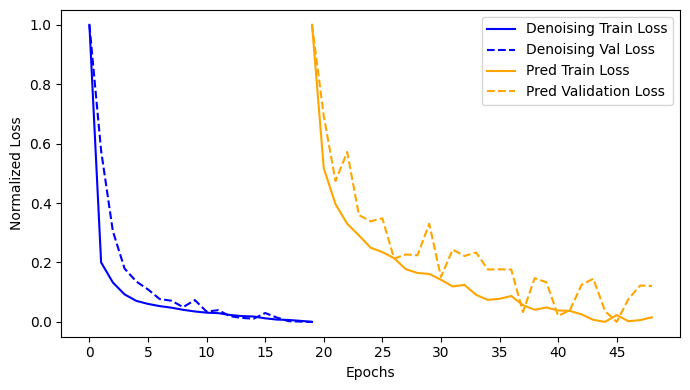

In [21]:
# Only plot if actual training was done
if load_trained_denoise_model == False and load_trained_pred_model == False:

    fig, ax = plt.subplots(1, 1, figsize=(7, 4))

    # Normalize the loss values to [0, 1] for better visualization
    denoise_train_loss_list = (denoise_train_loss_list - np.min(denoise_train_loss_list)) / (np.max(denoise_train_loss_list) - np.min(denoise_train_loss_list))
    denoise_val_loss_list = (denoise_val_loss_list - np.min(denoise_val_loss_list)) / (np.max(denoise_val_loss_list) - np.min(denoise_val_loss_list))
    pred_train_loss_list = (pred_train_loss_list - np.min(pred_train_loss_list)) / (np.max(pred_train_loss_list) - np.min(pred_train_loss_list))
    pred_val_loss_list = (pred_val_loss_list - np.min(pred_val_loss_list)) / (np.max(pred_val_loss_list) - np.min(pred_val_loss_list))

    # Just plotting the losses
    ax.plot(list(range(denoise_epochs)), denoise_train_loss_list, label='Denoising Train Loss', color='blue')
    ax.plot(list(range(denoise_epochs)), denoise_val_loss_list, label='Denoising Val Loss', color='blue', linestyle='--')
    ax.plot(list(range(denoise_epochs - 1, pred_epochs + denoise_epochs - 1)), pred_train_loss_list, label='Pred Train Loss', color='orange')
    ax.plot(list(range(denoise_epochs - 1, pred_epochs + denoise_epochs - 1)), pred_val_loss_list, label='Pred Validation Loss', color='orange', linestyle='--')
    ax.legend()
    ax.set_xlabel('Epochs')
    ax.set_xticks(list(range(0, pred_epochs + denoise_epochs, 5)))
    ax.set_ylabel('Normalized Loss')

    plt.tight_layout()
    fig.savefig("figures/loss_plot.jpg", dpi=300)
    plt.show()

# Prediction

In [22]:
def pred_with_TTA(model, loader, batch_size: int=16, lr: float=0.001, stdzer:Standardizer=None):
    # Predict with test-time adaptation (TTA)
    # Since the batch size is fixed, and we only want to use a single sample for the augmentation training step,
    # we need a batch with the same sample repeated batch_size times

    # Unfreeze the encoder
    for param in model.encoder.parameters():
        param.requires_grad = True

    # Unfreeze the decoder
    for param in model.decoder.parameters():
        param.requires_grad = True

    # Freeze the prediction head
    for param in model.head.parameters():
        param.requires_grad = False

    model = deepcopy(model).to(device)
    model_before_step = deepcopy(model).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    preds = []

    for batch in loader:
        
        model.set_mode('denoise')
        model.train()

        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        result = loss(out, batch.x)
        result.backward()
        optimizer.step()

        model.set_mode('predict')
        model.eval()

        with torch.no_grad():
            batch = batch.to(device)
            out = model(batch)
            pred = stdzer(out, rev=True)
            preds.extend(pred.cpu().detach().tolist())

        model = deepcopy(model_before_step)
        
    return preds[::batch_size]

In [23]:
class RepeatedDataset(Dataset):
    def __init__(self, base_dataset, repeat: int=16):
        self.base = base_dataset
        self.repeat = repeat
        self.base_len = len(base_dataset)

    def __len__(self):
        # Each original sample is repeated `repeat` times
        return self.base_len * self.repeat

    def __getitem__(self, idx):
        sample_idx = idx // self.repeat
        return deepcopy(self.base[sample_idx])

def construct_single_sample_loader(data_df, smi_column: str, target_column: str, shuffle: bool=True, batch_size: int=16):
    # Constructs a DataLoader for a single sample repeated "batch_size" times
    # This is needed for test-time adaptation (TTA)
    # Unfortunately, therefore the actual inference time takes "batch_size" times longer

    smiles = data_df[smi_column].values
    labels = data_df[target_column].values.astype(np.float32)

    base_dataset = ChemDataset(smiles, labels, precompute=True)
    # Each sample is repeated "batch_size" times
    repeated_dataset = RepeatedDataset(base_dataset, repeat=batch_size)

    # Each batch is a single repeated sample of size "batch_size"
    loader = DataLoader(
        dataset=repeated_dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        pin_memory=True
    )
    return loader

In [24]:
# Prediction without TTA
preds = pred(best_pred_model, test_loader, mode='predict', stdzer=stdzer)
print('Results on test set without TTA:')  
print(f"Test RMSE: {root_mean_squared_error(preds, test_loader.dataset.labels):.4g}")
print(f"Test MAE: {mean_absolute_error(preds, test_loader.dataset.labels):.4g}")

Results on test set without TTA:
Test RMSE: 1.355
Test MAE: 0.9633


In [25]:
# Prediction with TTA
# Can take a minute or two
# Takes longer for larger batch sizes, so its a trade off against training times when choosing the batch size
test_loader_single = construct_single_sample_loader(test_df, 'SMILES', 'LogS', shuffle=False, batch_size=batch_size)
# Depending on how large the batch size is, TTA inference will take "batch_size" times longer
preds_TTA = pred_with_TTA(best_pred_model, test_loader_single, stdzer=stdzer)
print('Results on test set with TTA:')
print(f"Test RMSE: {root_mean_squared_error(preds_TTA, test_loader.dataset.labels):.4g}")
print(f"Test MAE: {mean_absolute_error(preds_TTA, test_loader.dataset.labels):.4g}")

Precomputing data...
Precomputation finished. 2215 molecules cached.
Results on test set with TTA:
Test RMSE: 1.355
Test MAE: 0.9632


# Analysis

### Getting the Embeddings

In [26]:
def embeddings_with_TTA(model, loader, batch_size: int=16, lr: float=0.0005, stdzer:Standardizer=None):
    # Get embeddings with test-time adaptation (TTA)
    # Since the batch size is fixed, and we only want to use a single sample for the augmentation training step,
    # we need a batch with the same sample repeated batch_size times

    # Unfreeze the encoder
    for param in model.encoder.parameters():
        param.requires_grad = True

    # Unfreeze the decoder
    for param in model.decoder.parameters():
        param.requires_grad = True

    # Freeze the prediction head
    for param in model.head.parameters():
        param.requires_grad = False

    model = deepcopy(model).to(device)
    model_before_step = deepcopy(model).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    embeddings = []

    for batch in loader:
        
        model.set_mode('denoise')
        model.train()

        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        result = loss(out, batch.x)
        result.backward()
        optimizer.step()

        model.set_mode('predict')
        model.eval()

        with torch.no_grad():
            batch = batch.to(device)
            embedding = model.get_embedding(batch)
            embeddings.extend(embedding[::batch_size].cpu().detach().numpy())

        model = deepcopy(model_before_step)
        
    return embeddings

In [27]:
best_denoise_model = best_denoise_model.to(device)

# Getting embeddings for analysis using PCA
# The embeddings are lists of length "samples" of vectors with length "hidden_size"
train_embeddings = []
for batch in train_loader:
    batch = batch.to(device)
    embedding = best_denoise_model.get_embedding(batch)
    train_embeddings.extend(embedding.cpu().detach().numpy())

val_embeddings = []
for batch in val_loader:
    batch = batch.to(device)
    embedding = best_denoise_model.get_embedding(batch)
    val_embeddings.extend(embedding.cpu().detach().numpy())

test_embeddings = []
for batch in test_loader:
    batch = batch.to(device)
    embedding = best_denoise_model.get_embedding(batch)
    test_embeddings.extend(embedding.cpu().detach().numpy())

# Create and fit PCA
pca = PCA(n_components=2)
train_embeddings_2d = pca.fit_transform(np.array(train_embeddings))
val_embeddings_2d = pca.transform(np.array(val_embeddings))
test_embeddings_2d = pca.transform(np.array(test_embeddings))
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

# Also getting the test set embeddings after TTA
test_embeddings_with_TTA = embeddings_with_TTA(best_denoise_model, test_loader_single, lr=0.001, stdzer=stdzer)
test_embeddings_with_TTA_2d = pca.transform(np.array(test_embeddings_with_TTA))

Explained variance ratio: [0.46403566 0.21465471]


### Analyzing the Solubility Distribution

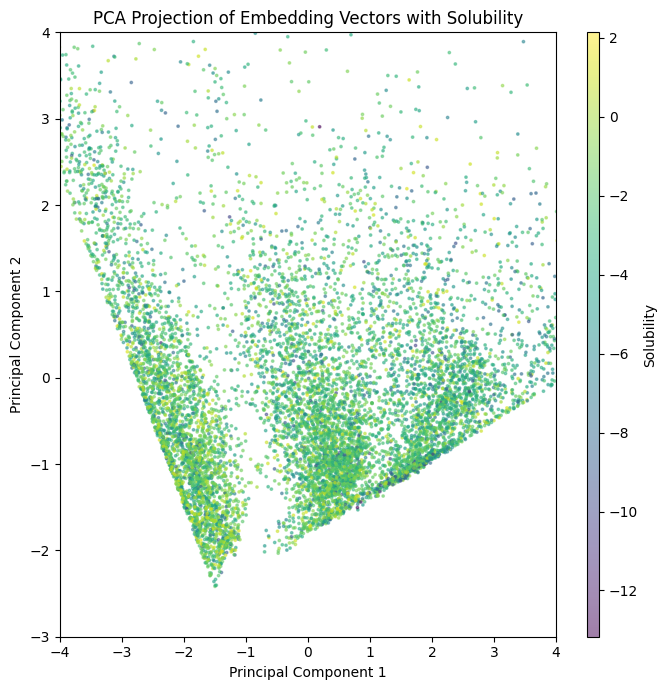

In [34]:
# Get the solubility values from each dataset
train_solubility = train_loader.dataset.labels
val_solubility = val_loader.dataset.labels
test_solubility = test_loader.dataset.labels

# Create a single figure and axes
fig, ax = plt.subplots(figsize=(7, 7))

# Define a consistent colormap for solubility
cmap = plt.cm.viridis
norm = plt.Normalize(min(min(train_solubility), min(val_solubility), min(test_solubility)),
                     max(max(train_solubility), max(val_solubility), max(test_solubility)))

# Plot all datasets on the same axes with different markers
sc1 = ax.scatter(train_embeddings_2d[:, 0], train_embeddings_2d[:, 1], 
                c=train_solubility, cmap=cmap, norm=norm, alpha=0.5, s=3)
sc2 = ax.scatter(val_embeddings_2d[:, 0], val_embeddings_2d[:, 1], 
                c=val_solubility, cmap=cmap, norm=norm, alpha=0.5, s=3)
sc3 = ax.scatter(test_embeddings_2d[:, 0], test_embeddings_2d[:, 1], 
                c=test_solubility, cmap=cmap, norm=norm, alpha=0.5, s=3)

# Add a colorbar, title, labels, and legend
cbar = fig.colorbar(sc1, ax=ax, aspect=50)
cbar.set_label('Solubility')
ax.set_title('PCA Projection of Embedding Vectors with Solubility')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_xlim(-4, 4)
ax.set_ylim(-3, 4)

plt.tight_layout()
fig.savefig("figures/pca_solubility.jpg", dpi=300)
plt.show()

### Analyzing the Class Distribution and Effect of TTA

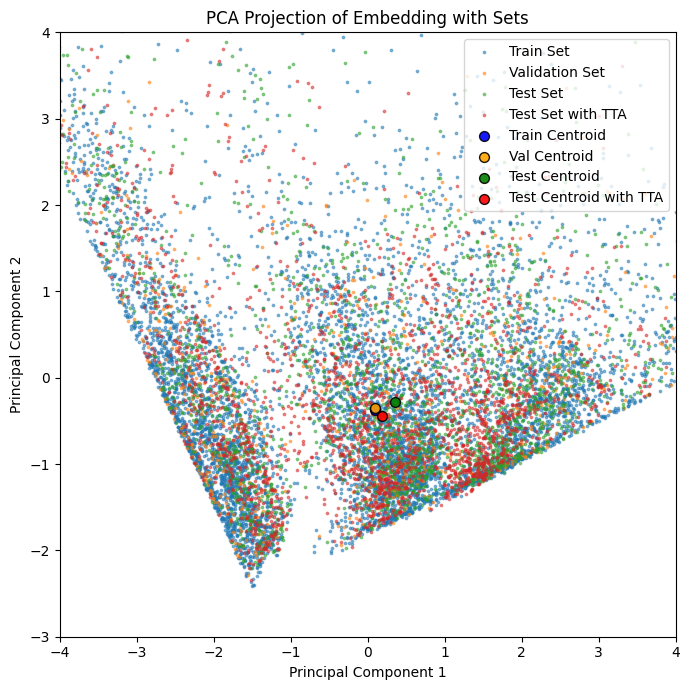

In [35]:
# Plot the 2D embeddings using fig, ax
fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(train_embeddings_2d[:, 0], train_embeddings_2d[:, 1], alpha=0.5, label='Train Set', s=3)
ax.scatter(val_embeddings_2d[:, 0], val_embeddings_2d[:, 1], alpha=0.5, label='Validation Set', s=3)
ax.scatter(test_embeddings_2d[:, 0], test_embeddings_2d[:, 1], alpha=0.5, label='Test Set', s=3)
ax.scatter(test_embeddings_with_TTA_2d[:, 0], test_embeddings_with_TTA_2d[:, 1], alpha=0.5, label='Test Set with TTA', s=3)

# Calculate centroids with median insetad of mean since we have outliers
train_centroid = np.median(train_embeddings_2d, axis=0)
val_centroid = np.median(val_embeddings_2d, axis=0)
test_centroid = np.median(test_embeddings_2d, axis=0)
test_tta_centroid = np.median(test_embeddings_with_TTA_2d, axis=0)

# Plot centroids with larger markers
ax.scatter(train_centroid[0], train_centroid[1], s=50, 
           c='blue', marker='o', edgecolors='black', linewidths=1, label='Train Centroid', alpha=0.9)
ax.scatter(val_centroid[0], val_centroid[1], s=50, 
           c='orange', marker='o', edgecolors='black', linewidths=1, label='Val Centroid', alpha=0.9)
ax.scatter(test_centroid[0], test_centroid[1], s=50, 
           c='green', marker='o', edgecolors='black', linewidths=1, label='Test Centroid', alpha=0.9)
ax.scatter(test_tta_centroid[0], test_tta_centroid[1], s=50, 
           c='red', marker='o', edgecolors='black', linewidths=1, label='Test Centroid with TTA', alpha=0.9)

ax.legend()
ax.set_title('PCA Projection of Embedding with Sets')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_xlim(-4, 4)
ax.set_ylim(-3, 4)

plt.tight_layout()
fig.savefig("figures/pca_sets.jpg", dpi=300)
plt.show()

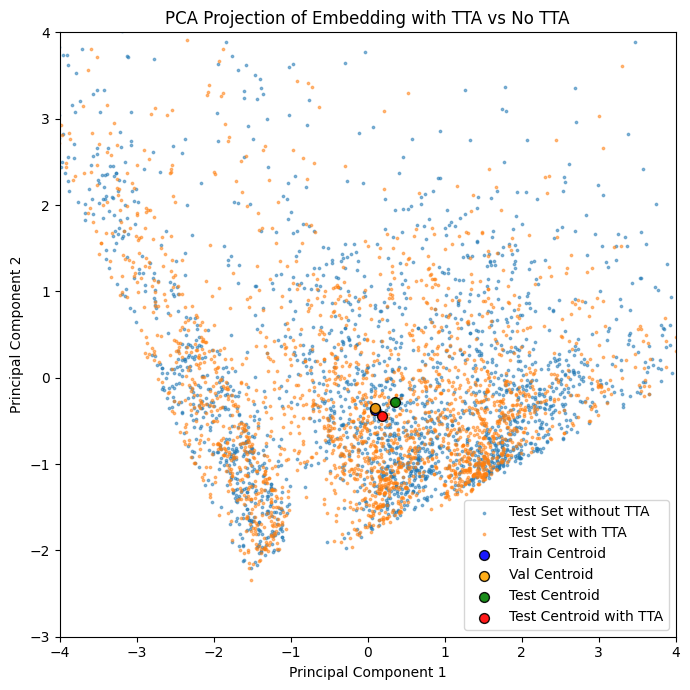

In [36]:
# Plot the 2D embeddings using fig, ax
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(test_embeddings_2d[:, 0], test_embeddings_2d[:, 1], alpha=0.5, label='Test Set without TTA', s=3)
ax.scatter(test_embeddings_with_TTA_2d[:, 0], test_embeddings_with_TTA_2d[:, 1], alpha=0.5, label='Test Set with TTA', s=3)

# Plot centroids with larger markers
ax.scatter(train_centroid[0], train_centroid[1], s=50, 
           c='blue', marker='o', edgecolors='black', linewidths=1, label='Train Centroid', alpha=0.9)
ax.scatter(val_centroid[0], val_centroid[1], s=50, 
           c='orange', marker='o', edgecolors='black', linewidths=1, label='Val Centroid', alpha=0.9)
ax.scatter(test_centroid[0], test_centroid[1], s=50, 
           c='green', marker='o', edgecolors='black', linewidths=1, label='Test Centroid', alpha=0.9)
ax.scatter(test_tta_centroid[0], test_tta_centroid[1], s=50, 
           c='red', marker='o', edgecolors='black', linewidths=1, label='Test Centroid with TTA', alpha=0.9)

ax.legend()
ax.set_title('PCA Projection of Embedding with TTA vs No TTA')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_xlim(-4, 4)
ax.set_ylim(-3, 4)

plt.tight_layout()
fig.savefig("figures/pca_sets_TTA_vs_no_TTA.jpg", dpi=300)
plt.show()